# To-Dos

In [1]:
## Outlier Removal
## Pull today versus pull history

# Import Packages

In [2]:
check.packages = function(pkg) {
    new.pkg = pkg[!(pkg %in% installed.packages()[, "Package"])]
    if (length(new.pkg)) 
        install.packages(new.pkg, dependencies = TRUE)
    sapply(pkg, require, character.only = TRUE)
}

In [58]:
check.packages(c('RPostgreSQL', 'RJDBC', 'ggplot2', 'dplyr', 'gridExtra', 'cowplot', 'ggplotify', 'rJava', 'ggpubr', 'lubridate', 'mailR', 'zoo', 'devtools','profvis'))

RPostgreSQL       RJDBC     ggplot2       dplyr   gridExtra     cowplot 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
  ggplotify       rJava      ggpubr   lubridate       mailR         zoo 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
   devtools     profvis 
       TRUE        TRUE

In [5]:
## Prevent scientific notation.
options(scipen = 999)

##Turn Warnings off.
options(warn = -1)

## Warnings back on.
# options(warn = 0)

# Connect to Databases

In [6]:
killDbConnections = function () {
  all_cons = dbListConnections(PostgreSQL())
  print(all_cons)
  for(con in all_cons)
    +  dbDisconnect(con)
  
#   print(paste(length(all_cons), " connections killed."))
}

In [7]:
checkConnections = function() {
    
    print(paste(length(dbListConnections(PostgreSQL())), " connections active."))
}

### Reporting

In [8]:
createReportingConnectionObject = function() {
    
    killDbConnections()
    
    drv = dbDriver('PostgreSQL')

    reporting = dbConnect(
      drv,
      dbname = 'reporting',
      host = 'reporting.ckpglb17yttu.us-east-1.rds.amazonaws.com',
      port = 5432,
      user = Sys.getenv('REPORTING_USER'),
      password = Sys.getenv('REPORTING_PASS')
    )
}

### Heap

In [9]:
createHeapConnectionObject = function() {
    
    killDbConnections()
    
    drv = dbDriver('PostgreSQL')

    reporting = dbConnect(
      drv,
      dbname = 'oppreddb',
      host = 'oppred.cyt7r7wgkc6b.us-east-1.redshift.amazonaws.com',
      port = 5439,
      user = Sys.getenv('HEAP_USER'),
      password = Sys.getenv('HEAP_PASS')
    )
}

# Get Data

### Reporting -- Funnel Numbers

In [10]:
## This returns counts of each status occurrence, grouped by DOY, DOW, and HOD.

getFunnel = function(date.string) {
    
    df = dbGetQuery(
        createReportingConnectionObject(),
        paste(
            "
            with time_limit_gmt as 
            (
                select
                    date_trunc('hour', min(createddate_)) as createddate_
                from
                    (
                    select
                        max(createddate) as createddate_
                    from
                        cloudlending.application_status_history
                    union all
                    select
                        max(createddate) as createddate_
                    from
                        cloudlending.applications
                    union all
                    select
                        max(createddate) as createddate_
                    from
                        cloudlending.microbilt_information
                    ) as latest_dates
            )  
            select
                (c_ash.createddate at time zone 'America/Chicago')::date as dayofyear
                , extract(dow from c_ash.createddate at time zone 'America/Chicago') as dayofweek
                , extract(hour from c_ash.createddate at time zone 'America/Chicago') as hourofday
                , count(distinct case 	when old_value = 'BUSINESS RULES PASSED' and new_value = 'BUREAU APPROVED' then c_app.id end) as qualified
                , count(distinct case 	when new_value = 'BANK VERIFICATION COMPLETED' or (old_value in ('AUTO BANK VERIFICATION FAILED', 'REVIEW REQUIRED - BANK VERIFICATION') and new_value = 'NEW - SCORECARD GENERATED') then c_app.id end) as bankverified
                , count(distinct case 	when old_value = 'NEW - PRICING GENERATED' and new_value in ('CONTRACT SIGNED', 'WAITING ON STIPULATIONS') then c_app.id end) as passscorecardratecard
                , count(distinct case 	when old_value in ('NEW - PRICING GENERATED', 'WAITING ON STIPULATIONS') and new_value = 'CONTRACT SIGNED' then c_app.id end) as contractsigned
                , count(distinct case 	when (c_ash.old_value in ('NEW - PRICING GENERATED', 'WAITING ON STIPULATIONS') and c_ash.new_value = 'CONTRACT SIGNED' and c_app.denialreason in ('Agent', 'Denied - Bankruptcy', 'Denied - First Payment Date', 'Verify'))
                                        or (c_ash.new_value = 'LOAN APPROVED' and c_ash.old_value != c_ash.new_value)
                                        then c_app.id end) as cs_decisioned
                , count(distinct case 	when new_value = 'LOAN APPROVED' and old_value != new_value then c_app.id end) as funded
                , case 	when (c_ash.createddate at time zone 'America/Chicago')::date = '", date.string, "'::date
                        then 'test'	
                        else 'training'
                        end as grouping
                , count(distinct case 	when ibv_source = 'DecisionLogic' then c_app.id end) as ", '"bankverified.dl"', "
                , count(distinct case 	when ibv_source = 'MicroBilt' then c_app.id end) as ", '"bankverified.mb"', " 
            from
                cloudlending.applications as c_app
                inner join
                    cloudlending.application_status_history as c_ash
                    on c_app.id = c_ash.application
                left join
                    cloudlending.microbilt_information as c_mb
                    on c_ash.application = c_mb.application
                    and abs(extract(epoch from c_ash.createddate - c_mb.createddate)) <= 30
                    and c_ash.new_value = 'BANK VERIFICATION COMPLETED'
                inner join
                    time_limit_gmt
                    on TRUE
            where
                c_app.createddate < createddate_
                and c_ash.createddate < createddate_
                and (c_ash.createddate at time zone 'America/Chicago')::date >= '", date.string, "'::date - '3 months'::interval
                and (c_ash.createddate at time zone 'America/Chicago')::date <= '", date.string, "'::date
                and type_formula = 'New'
            group by
                dayofyear
                , dayofweek
                , hourofday
                , grouping
            order by
                dayofyear asc
                , hourofday asc
            ",
            sep = ''
        )
    )
    
    return(df)
}

### Reporting -- Last Refresh

In [11]:
## This returns the latest full refresh of the data used. To be put into caption of plots.

getLatestReportingRefresh = function() {
    
    dbGetQuery(
        createReportingConnectionObject(),
        paste(
            "
            select
                date_trunc('hour', min(createddate_)) as createddate_
            from
                (
                select
                    max(createddate at time zone 'America/Chicago') as createddate_
                from
                    cloudlending.application_status_history
                union all
                select
                    max(createddate at time zone 'America/Chicago') as createddate_
                from
                    cloudlending.applications
                union all
                select
                    max(createddate at time zone 'America/Chicago') as createddate_
                from
                    cloudlending.microbilt_information
                ) as latest_dates
            ",
            sep = ''
        )
    )$createddate_
}

### Heap -- IBV Attempts

In [12]:
## This returns a data frame of all the apps that attempt DL.

getAttemptDLRaw = function(date.string) {
    
    df.heap = dbGetQuery(
        createHeapConnectionObject(),
        paste(
            "
            select
                h_users.", '"', 'identity', '"', " as contact
                , h_dl.time at time zone 'GMT' at time zone 'America/Chicago' as time_
                , 'DecisionLogic' as ibv_source
                , case  when (h_dl.time at time zone 'GMT' at time zone 'America/Chicago')::date = '", date.string, "'::date
                        then 'test'
                        else 'training'
                        end as grouping
            from
                main_production._completed_decisionlogic_iframe_ as h_dl
                inner join
                    main_production.users as h_users
                    on h_dl.user_id = h_users.user_id
            where
                (h_dl.time at time zone 'GMT' at time zone 'America/Chicago')::date >= '", date.string, "'::date - '3 months'::interval
                and (h_dl.time at time zone 'GMT' at time zone 'America/Chicago')::date <= '", date.string, "'::date
            ",
            sep = ''
        )
    )

    df.reporting = dbGetQuery(
        createReportingConnectionObject(),
        paste(
            "
            select
                name
                , createddate at time zone 'America/Chicago' as createddate_
                , contact
            from
                cloudlending.applications
            where 
              type_formula = 'New'
              and (createddate at time zone 'America/Chicago')::date >= '", date.string, "'::date - '4 months'::interval
              and (createddate at time zone 'America/Chicago')::date <= '", date.string, "'::date
            "
        )
    )
    

    df.merged = merge(
        x = df.heap,
        y = df.reporting,
        by.x = 'contact',
        by.y = 'contact'
    )
    
    df.boxed = df.merged[
        which(
            df.merged$time_ >= df.merged$createddate_ & 
            as.Date(df.merged$time_) <= as.Date(df.merged$createddate_) + 15
        ), ]
    
    df.unique = df.boxed %>%
        group_by(
            name,
            grouping
        ) %>%
        summarize(
            time_ = min(time_)
        )

    return(df.unique)
    
}

In [13]:
## This returns a data frame of all the apps that attempt MB.

getAttemptMBRaw = function(date.string) {
    
    df.heap = dbGetQuery(
        createHeapConnectionObject(),
        paste(
            "
            select
                h_users.", '"', 'identity', '"', " as contact
                , h_mb.time at time zone 'GMT' at time zone 'America/Chicago' as time_
                , 'MicroBilt' as ibv_source
                , case  when (h_mb.time at time zone 'GMT' at time zone 'America/Chicago')::date = '", date.string, "'::date
                        then 'test'
                        else 'training'
                        end as grouping
            from
                main_production._completed_microbilt_iframe_ as h_mb
                inner join
                    main_production.users as h_users
                    on h_mb.user_id = h_users.user_id
            where
              (h_mb.time at time zone 'GMT' at time zone 'America/Chicago')::date >= '", date.string, "'::date - '3 months'::interval
              and (h_mb.time at time zone 'GMT' at time zone 'America/Chicago')::date <= '", date.string, "'::date
            ",
            sep = ''
        )
    )

    df.reporting = dbGetQuery(
        createReportingConnectionObject(),
        paste(
            "
            select
                name
                , createddate at time zone 'America/Chicago' as createddate_
                , contact
            from
                cloudlending.applications
            where 
              type_formula = 'New'
              and (createddate at time zone 'America/Chicago')::date >= '", date.string, "'::date - '4 months'::interval
              and (createddate at time zone 'America/Chicago')::date <= '", date.string, "'::date
            "
        )
    )
    

    df.merged = merge(
        x = df.heap,
        y = df.reporting,
        by.x = 'contact',
        by.y = 'contact'
    )
    
    df.boxed = df.merged[
        which(
            df.merged$time_ >= df.merged$createddate_ & 
            as.Date(df.merged$time_) <= as.Date(df.merged$createddate_) + 15
        ), ]
    
    df.unique = df.boxed %>%
        group_by(
            name,
            grouping
        ) %>%
        summarize(
            time_ = min(time_)
        )

    
    return(df.unique)
    
}

In [14]:
## This unions the above raw DL and MB attempts, and only retains the first IBV attempt.
## This is done outside of the query due to troubles connecting to JDBC AWS - can't use subqueries in current connection.

getAttemptBothRaw = function (dl.data.raw, mb.data.raw) {
    
    data.both = rbind(
        dl.data.raw, 
        mb.data.raw
    )
    
    df.unique = data.both %>%
        group_by(
            name,
            grouping
        ) %>%
        summarize(
            time_ = min(time_)
        )
    
    return(df.unique)
    
}

In [15]:
## This groups either DL, MB, or All attempts (if NA) into DOY, DOW, HOD.

getAttemptAggregate = function(data, ibv.provider = NA) {
    
    df.unique = data
    
    df.aggregated = df.unique %>%
        group_by(
            dayofyear = date(time_),
            dayofweek = ifelse(
                wday(time_, week_start = getOption("lubridate.week.start", 1)) == 7,
                0,
                wday(time_, week_start = getOption("lubridate.week.start", 1))),
            hourofday = hour(time_),
            grouping
        ) %>%
        summarize(
            attempt.ibv = n_distinct(name)
        )

    if (!is.na(ibv.provider)) {
        colnames(df.aggregated)[which(colnames(df.aggregated) == 'attempt.ibv')] = ifelse(
            ibv.provider == 'DecisionLogic',
            'attempt.dl',
            'attempt.mb'
        )
    }
    
    return(df.aggregated)
    
}

### Heap -- Last Refresh

In [16]:
## This returns the lastest full refresh of the data used. Used for limiting the time and caption in the ggplots below.

getLatestHeapRefresh = function() {
    
    dbGetQuery(
        createHeapConnectionObject(),
        paste(
            "
            select
                date_trunc('hour', min(time_)) as time_
            from
                (
                select
                    max(time at time zone 'GMT' at time zone 'America/Chicago') as time_
                from
                    main_production._completed_decisionlogic_iframe_
                union all
                select
                    max(time at time zone 'GMT' at time zone 'America/Chicago') as time_
                from
                    main_production._completed_microbilt_iframe_
                ) as latest_dates
            ",
            sep = ''
        )
    )$time_
}

### Merge Heap to Funnel

In [17]:
## This returns a final data frame that includes all the above status occurrence counts, grouped by DOY, DOW, and HOD.

getDf = function(reporting.data, dl.data.raw, mb.data.raw) {
    
    dl.data = getAttemptAggregate(
        data = dl.data.raw,
        ibv.provider = 'DecisionLogic'
    )
    mb.data = getAttemptAggregate(
        data = mb.data.raw,
        ibv.provider = 'MicroBilt'
    )
    both.data = getAttemptAggregate(
        data = getAttemptBothRaw(
            dl.data.raw = dl.data.raw,
            mb.data.raw = mb.data.raw
        )
    )
    
    merged.data.dl = merge(
        x = reporting.data,
        y = dl.data,
        by.x = c('dayofyear', 'dayofweek', 'hourofday', 'grouping'),
        by.y = c('dayofyear', 'dayofweek', 'hourofday', 'grouping'),
        all.x = TRUE
    )
    
    merged.data.mb = merge(
        x = merged.data.dl,
        y = mb.data,
        by.x = c('dayofyear', 'dayofweek', 'hourofday', 'grouping'),
        by.y = c('dayofyear', 'dayofweek', 'hourofday', 'grouping'),
        all.x = TRUE
    )
    
    merged.data.both = merge(
        x = merged.data.mb,
        y = both.data,
        by.x = c('dayofyear', 'dayofweek', 'hourofday', 'grouping'),
        by.y = c('dayofyear', 'dayofweek', 'hourofday', 'grouping'),
        all.x = TRUE
    )
    
#     merged.data.both$attempt.dl = ifelse(
#         is.na(merged.data.both$attempt.dl),
#         0,
#         merged.data.both$attempt.dl
#     )
#     merged.data.both$attempt.mb = ifelse(
#         is.na(merged.data.both$attempt.mb),
#         0,
#         merged.data.both$attempt.mb
#     )
#     merged.data.both$attempt.ibv = ifelse(
#         is.na(merged.data.both$attempt.ibv),
#         0,
#         merged.data.both$attempt.ibv
#     )
    
    
    return(merged.data.both)
    
}

In [18]:
## This takes the overall data frame, and only keeps the numerator and denominator specified.
## This also makes any un-refreshed data sources (usually Heap) and turns the NAs to 0.
## Finally, attaches a column

limitDf = function(data, numerator.string = NA, denominator.string = NA) {
        
    df = data[ , which(colnames(data) %in% c('dayofyear', 'dayofweek', 'hourofday', 'grouping', denominator.string, numerator.string))]
    df.reorder = df[ , c(
        which(colnames(df) == 'dayofyear'),
        which(colnames(df) == 'dayofweek'),
        which(colnames(df) == 'hourofday'),
        which(colnames(df) == 'grouping'),
        which(colnames(df) == denominator.string),
        which(colnames(df) == numerator.string))]
    
    colnames(df.reorder) = c('dayofyear', 'dayofweek', 'hourofday', 'grouping', 'denominator', 'numerator')
    
    
    df.reorder$denominator = ifelse(
        is.na(df.reorder$denominator),
        0,
        df.reorder$denominator
    )
    df.reorder$numerator = ifelse(
        is.na(df.reorder$numerator),
        0,
        df.reorder$numerator
    )
    
    df.ordered = df.reorder[order(df.reorder$dayofyear, df.reorder$hourofday), ]
    
    
    need.heap.tag.strings = c('attempt.dl', 'attempt.mb', 'attempt.ibv')
    df.ordered.heap.tagged = data.frame(
        df.ordered,
        heap.time.tag = ifelse(
            numerator.string %in% need.heap.tag.strings |
            denominator.string %in% need.heap.tag.strings,
            rep(1, nrow(df.ordered)),
            rep(0, nrow(df.ordered))
        )
    )
    
    
    return(df.ordered.heap.tagged)
}

### Remove largest and smallest ratio for each group

In [19]:
# ## 2018-12-18 -- Wells Fargo DL Outage
# ## 2018-12-20 -- Everything OK
# ## 2010-01-01 -- Complete DL Outage
# ## 2019-01-04 -- Chase DL Errors
# ## 2019-01-05 -- Chase DL Errors
# ## 2019-01-06 -- Chase DL Errors
# ## 2019-01-07 -- Chase DL Errors
# ## 2019-01-08 -- Chase DL Errors
# ## 2019-01-13 -- NFCU DL Errors
# ## 2019-01-17 -- Everything OK
# ## 2019-01-18 -- Everything OK
# ## 2019-01-19 -- Everything OK
# ## 2019-01-20 -- Everything OK
# ## 2019-01-21 -- Everything OK
# ## 2019-01-22 -- Everything OK
# # 2019-01-23 -- Everything OK
# # 2019-01-29 -- Early DL Issues with Chase
# 2019-02-07 -- Early DL Issues with Wells Fargo

In [20]:
## This is to be used right before aggregation into DOW/HOD - after makeCumulative() when cumulative == TRUE.

removeEdges = function (data.limited) {
    
    
    bad.training.dates = as.Date(c('2018-12-12', '2019-01-01'))
    
    data.training = data.limited[which(data.limited$grouping == 'training' & !(data.limited$dayofyear %in% bad.training.dates)), ]
    
#     data.ratios = data.frame(
#         data.training,
#         ratio = ifelse(
#             data.training$denominator != 0,
#             data.training$numerator/data.training$denominator,
#             0
#         )
#     )
    
#     data.minimum = data.ratios %>%
#         group_by(
#             dayofweek,
#             hourofday
#         ) %>%
#         summarize(
#             min.ratio = min(ratio)
#         )
    
#     data.ratios.tagged = data.frame(
#         data.ratios,
#         is.min = ifelse(
#             paste(data.ratios$dayofweek, data.ratios$hourofday, data.ratios$ratio) %in% paste(data.minimum$dayofweek, data.minimum$hourofday, data.minimum$min.ratio),
#             1,
#             0
#         )
#     )
    
#     data.no.minimum = data.ratios.tagged[which(data.ratios.tagged$is.min == 0), ]
    
#     return(data.no.minimum)
    
    return(data.training)
}

### Reporting -- Checks and Balances: Apps in Contract Signed

In [21]:
## This returns the last known count of apps in status CONTRACT SIGNED in a dataframe.

checkCS = function () {
    dbGetQuery(
        createReportingConnectionObject(),
        "
        select 
            max(createddate at time zone 'America/Chicago') as last_update
            , count(case when status = 'CONTRACT SIGNED' then id end) as count_cs
        from
            cloudlending.applications
        where
            createddate >= now() - '15 days'::interval
        "
    )
}

In [22]:
## This returns the last known count of apps with owner UW QUEUE in a dataframe.

checkUWQ = function () {
    dbGetQuery(
        createReportingConnectionObject(),
        "
        select
            max(createddate_) as last_update
            , count(*) as count_uwq
        from
            (
                select
                    c_hist.parentid as application
                    , c_hist.createddate at time zone 'America/Chicago' as createddate_
                    , c_hist.newvalue
                    , row_number() over (partition by c_hist.parentid order by c_hist.createddate desc) as rn
                from
                    cloudlending.applications_history as c_hist
                    inner join
                        cloudlending.applications as c_app
                        on c_hist.parentid = c_app.id
                where
                    c_hist.field = 'Owner'
                    and c_app.status not in ('DENIED', 'LOAN APPROVED')
          ) as with_rn
        where
            rn = 1
            and newvalue = '00G50000002rxZ4EAI'
        "
    )
}

# Separate the data

### Session // Test

In [23]:
## Input data frame.
## Output list of DOY, DOW, HOURS.

getSessionInfo = function(data) {
    
    df = data
    
    current.date = tail(
        df$dayofyear,
        1
    )

    current.day = tail(
        df$dayofweek,
        1
    )

    current.hours = seq(
        from = 0,
        to = 23,
        by = 1
    )

    session.info = list(
        date = current.date,
        dow = current.day,
        hours = current.hours
    )
    
    return(session.info)
    
}

In [24]:
## Input data frame.
## Output aggregated (cumulative) data for TEST DATA.

getSessionData = function(data, cumulative) {
    
    ## Create local variable on the parameter:DATA 
    df = data
    df.session = df[which(df$grouping == 'test'), ]

    
    if (cumulative == TRUE) {
        
        session.point.estimates = 
            df.session %>%
            group_by(
                dayofyear
            ) %>%
    #         mutate(
            transmute(
                hourofday = hourofday,
                denominator.session = cumsum(denominator),
                numerator.session = cumsum(numerator),
                ratio.session = ifelse(
                    cumsum(denominator) > 0,
                    cumsum(numerator)/cumsum(denominator),
                    0
                )
            )
    } else if (cumulative == FALSE) {
        
        session.point.estimates = 
        df.session %>%
        group_by(
            dayofyear,
            hourofday
        ) %>%
        summarize(
            denominator.session = sum(denominator),
            numerator.session = sum(numerator),
            ratio.session = ifelse(
                sum(denominator) > 0,
                sum(numerator)/sum(denominator),
                0
            )
        )
    }
    
    if (max(df$heap.time.tag == 1)) {
    
        if (max(as.Date(df.session$dayofyear)) == Sys.Date()) {
            
            session.point.estimates$denominator.session[which(session.point.estimates$hourofday > hour(getLatestHeapRefresh()))] = 0
            session.point.estimates$numerator.session[which(session.point.estimates$hourofday > hour(getLatestHeapRefresh()))] = 0
            session.point.estimates$ratio.session[which(session.point.estimates$hourofday > hour(getLatestHeapRefresh()))] = 0
        }
    }
    
    return(session.point.estimates)
}

### History // Training

In [25]:
## Input data frame.
## Output mutated (cumulative) data for TRAINING DATA.
## Reliant on getSessionInfo().

makeCumulative = function(data) {
    
    df = data
    
    df.hist = df[which(df$grouping == 'training'), ]
    
    df.hist.mutate = 
        df.hist[which(df.hist$dayofweek == getSessionInfo(data = df)$dow), ] %>%
        group_by(
            dayofyear,
            grouping
        ) %>%
        transmute(
            dayofweek = dayofweek,
            hourofday = hourofday,
            denominator = cumsum(denominator),
            numerator = cumsum(numerator)
        )
    
    return(df.hist.mutate)
    
}

In [26]:
## Input data frame.
## Output aggregated (cumulative) data for TRAINING DATA.
## Reliant on makeCumulative().

getHistoricalData = function(data, cumulative) {
    
    ## Create local variable on the parameter:DATA     
    df = data
    
    
    if (cumulative == TRUE) {
    
        df.hist.mutate = removeEdges(makeCumulative(data = df))

        historical.point.estimates = 
            df.hist.mutate %>%
            group_by(
                hourofday
            ) %>%
            summarize(
                denominator.hist = sum(denominator),
                numerator.hist = sum(numerator),
                r.hist = sum(numerator)/sum(denominator),
                n.hist = sum(denominator),
                sd.denominator.hist = sd(denominator),
                sd.numerator.hist = sd(numerator),
                mu.denominator.hist = mean(denominator),
                corr.hist = ifelse(is.na(cor(denominator, numerator)), 0, cor(denominator, numerator)),
                se.hist = sqrt(
                    (
                        (
                            sd(numerator)^2 + 
                            sd(denominator)^2 * (sum(numerator)/sum(denominator))^2 -
                            2 * sum(numerator)/sum(denominator) * ifelse(is.na(cor(denominator, numerator)),0,cor(denominator, numerator)) * sd(numerator) * sd(denominator)
                        ) /
                        (
                            sum(denominator) *
                            mean(denominator)^2
                        )
                    )
                )
            )
    } else if (cumulative == FALSE) {

        df.hist = removeEdges(df[which(df$grouping == 'training'), ])

        historical.point.estimates = 
            df.hist[which(df.hist$dayofweek == getSessionInfo(data = df)$dow), ] %>%
            group_by(
                hourofday
            ) %>%
            summarize(
                denominator.hist = sum(denominator),
                numerator.hist = sum(numerator),
                r.hist = sum(numerator)/sum(denominator),
                n.hist = sum(denominator),
                sd.denominator.hist = sd(denominator),
                sd.numerator.hist = sd(numerator),
                mu.denominator.hist = mean(denominator),
                corr.hist = ifelse(is.na(cor(denominator, numerator)), 0, cor(denominator, numerator)),
                se.hist = sqrt(
                    (
                        (
                            sd(numerator)^2 + 
                            sd(denominator)^2 * (sum(numerator)/sum(denominator))^2 -
                            2 * sum(numerator)/sum(denominator) * ifelse(is.na(cor(denominator, numerator)),0,cor(denominator, numerator)) * sd(numerator) * sd(denominator)
                        ) /
                        (
                            sum(denominator) *
                            mean(denominator)^2
                        )
                    )
                )
            )
    }

    return(historical.point.estimates)
}

# Run the bootstrap

In [27]:
## Input data frame.
## Output Initialized CI data frame.
## Reliant on getSessionDataCumulative() and getHistoricalDataCumulative().

getInitialCI = function(data, cumulative) {
    
    df = data
    
    df.session = getSessionData(data = df, cumulative = cumulative)
    df.historical = getHistoricalData(data = df, cumulative = cumulative)

    ci.information = data.frame(

        date.session = rep(max(as.Date(df.session$dayofyear)),24),
        hour.session = df.historical$hourofday,
        numerator.session = c(df.session$numerator.session, rep(0, 24 - length(df.session$numerator.session))),
        denominator.session = c(df.session$denominator.session, rep(0, 24 - length(df.session$denominator.session))),
        r.session = c(df.session$ratio.session, rep(0, 24 - length(df.session$ratio.session))),
        r.hist = df.historical$r.hist,
        se.hist = df.historical$se.hist,
        z.lower = rep(0,24),
        z.upper = rep(0,24),
        ci.lower = rep(0,24),
        ci.upper = rep(0,24)
    )
    
    return(ci.information)
}

In [28]:
## Input data frame and Bootstrap parameters.
## Output Finalized CI data frame.
## Reliant on getInitialCI() and makeCumulative().

getBootstrapInterval = function(data, cumulative, B, alpha) {
    
    df = data
    
#     ## Set Start Time.
#     start_time = Sys.time()
    
    ## Initialize final output data frame.
    ci.information = getInitialCI(data = df, cumulative = cumulative)
    
    
    
    ## Initialize data for bootstrap.
    if (cumulative == TRUE) {
        
        df.training.dow = makeCumulative(data = df)
    } else if (cumulative == FALSE) {
        
        df.training = df[which(df$grouping == 'training'), ]
        df.training.dow = df.training[which(df.training$dayofweek == getSessionInfo(data = df)$dow), ]
    }
    
        
    
    ## Initialize container for bootstrap.
    bootstrap_z = vector(length = B)
    
    ## Check for enough sample size
#     histPDF = getHistoricalData(
#         data = data,
#         cumulative = FALSE
#     )
    
    
    for (i in 1:24) {
        
#         if (histPDF$numerator.hist >= nrow(df.training.dow.hour) {

            for (j in 1:B) {



                ## Subset the data to the current HOD (i).
                df.training.dow.hour = df.training.dow[which(df.training.dow$hourofday == i - 1), ]

                index = seq(
                    1, 
                    nrow(df.training.dow.hour)
                )
                resample_index = sample(
                    x = index, 
                    size = length(index), 
                    replace = TRUE
                )
                df.training.dow.hour.resample = df.training.dow.hour[resample_index, ]


                ## Calculate statistics from the resample.
                r = sum(df.training.dow.hour.resample$numerator)/sum(df.training.dow.hour.resample$denominator)
                n = sum(df.training.dow.hour.resample$denominator)
                sx = sd(df.training.dow.hour.resample$denominator)
                sy = sd(df.training.dow.hour.resample$numerator)
                mx = mean(df.training.dow.hour.resample$denominator)
                corr = ifelse(is.na(cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator)),0,cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator))

                se = sqrt(
                    (r^2*sx^2 + sy^2 - 2*r*corr*sx*sy)/
                    (n*mx^2)
                )


                ## Calculate statistics from the training data.
                mu = ci.information$r.hist[i]


                ## Calculate the bootstrap Z
                bootstrap_z[j] = (r - mu)/se
            }
#         }


        ## For each hour, take Percentiles of the Bootstrap Z vector to caluclate the confidence interval for that hour.
        bootstrap_z = sort(bootstrap_z)

        ci.information$z.lower[i] = bootstrap_z[alpha/2*B]
        ci.information$z.upper[i] = bootstrap_z[(1-alpha/2)*B]

        ci.information$ci.lower = ci.information$r.hist - ci.information$z.upper * ci.information$se.hist
        ci.information$ci.upper = ci.information$r.hist - ci.information$z.lower * ci.information$se.hist
    }
    
    ci.information$ci.lower = ifelse(
        is.na(ci.information$ci.lower),
        0,
        ci.information$ci.lower
    )
    
    return(ci.information)
}

In [29]:
smoothLowerBound = function(ci.information, iterations) {
    
    ci.information.smooth = ci.information
    
    if (iterations >= 1) {
    
        for (i in 1:iterations) {

            for (j in (0+1):(23-1)) {

                ci.information.smooth$ci.lower[which(ci.information.smooth$hour.session == j)] = mean(
                    c(ci.information.smooth$ci.lower[which(ci.information.smooth$hour.session == j)-1], ci.information.smooth$ci.lower[which(ci.information.smooth$hour.session == j)+1])
                )
            }        
        }
    }
    
    return(ci.information.smooth)

}

# Create the ggplot

In [30]:
## Converts column name to common name.

getFunnelName = function(atStatus_string) {
    
    return_string = ''
    
    if (atStatus_string == 'qualified') {
        return_string = 'Q'
    }
    else if (atStatus_string == 'attempt.ibv') {
        return_string = 'Attempt IBV'
    }
    else if (atStatus_string == 'attempt.dl') {
        return_string = 'Attempt DL'
    }
    else if (atStatus_string == 'attempt.mb') {
        return_string = 'Attempt MB'
    }
    else if (atStatus_string == 'bankverified') {
        return_string = 'BV'
    }
    else if (atStatus_string == 'bankverified.dl') {
        return_string = 'Success DL'
    }
    else if (atStatus_string == 'bankverified.mb') {
        return_string = 'Success MB'
    }
    else if (atStatus_string == 'passscorecardratecard') {
        return_string = 'SC'
    }
    else if (atStatus_string == 'contractsigned') {
        return_string = 'CS'
    }
    else if (atStatus_string == 'cs_decisioned') {
        return_string = 'CS Decisioned'
    }
    else if (atStatus_string == 'funded') {
        return_string = 'F'
    }
    
    return(return_string)
    
}

In [31]:
## Converts column name to a specified color.

getFunnelColor = function(atStatus_string) {
    
    color.decimal = ''

    
    if (atStatus_string == 'attempt.ibv') {
        color.decimal = '#E76BF3'
    }
    else if (atStatus_string == 'attempt.dl') {
        color.decimal = '#00BA38'
    }
    else if (atStatus_string == 'attempt.mb') {
        color.decimal = '#FD61D1'
    }
    else if (atStatus_string == 'bankverified.dl') {
        color.decimal = '#00B0F6'
    }
    else if (atStatus_string == 'bankverified.mb') {
        color.decimal = '#E58700'
    }
    else if (atStatus_string == 'bankverified') {
        color.decimal = '#619CFF'
    }
    else if (atStatus_string == 'passscorecardratecard') {
        color.decimal = '#00C0AF'
    }
    else if (atStatus_string == 'contractsigned') {
        color.decimal = '#B983FF'
    }
    else if (atStatus_string == 'cs_decisioned') {
        color.decimal = '#C99800'
    }
    else if (atStatus_string == 'funded') {
        color.decimal = '#619CFF'
    }
    
    return(color.decimal)
    
}

In [32]:
## Returns current states of CS and UWQ

getSupportingTextPlot = function () {
    
    supporting.text = paste(
        '\n As of', checkCS()$last_update, 'there were', checkCS()$count_cs, 'apps that are in CONTRACT SIGNED. \n\n',
        'As of', checkUWQ()$last_update, 'there were', checkUWQ()$count_uwq, 'apps that are in the UW Queue.'
    )
    
    ggplot() + labs(caption = supporting.text) + theme(plot.caption = element_text(hjust = 0.5))
    
    
}

In [33]:
getWarningBackground = function(bi.cumulative.true = NA, bi.cumulative.false = NA, numerator.string = NA, denominator.string = NA) {

    plot.funnel = paste(getFunnelName(numerator.string),'/',getFunnelName(denominator.string), sep = '')
    
    reporting.refresh = getLatestReportingRefresh()
    heap.refresh = getLatestHeapRefresh()
    plot.hour.limit = ifelse(
        date(max(c(reporting.refresh, heap.refresh))) == Sys.Date(),
        ifelse(
            grepl('Attempt', plot.funnel), 
            hour(getLatestHeapRefresh()), 
            hour(getLatestReportingRefresh())
        ),
        23
    )

    

    c.true.tagged = data.frame(
        bi.cumulative.true,
        is.zero = ifelse(bi.cumulative.true$r.session == 0, 1, 0),
        is.low = ifelse(bi.cumulative.true$r.session < bi.cumulative.true$ci.lower, 1, 0)
    )[which(bi.cumulative.true$hour.session < plot.hour.limit), ]

    c.true.warning = data.frame(
        c.true.tagged,
        rolling.zero.2 = c(rep(0,1), rollmean(x = c.true.tagged$is.zero, k = 2, align = 'left')),
        rolling.low.2 = c(rep(0,1), rollmean(x = c.true.tagged$is.low, k = 2, align = 'left')),
        rolling.low.3 = c(rep(0,2), rollmean(x = c.true.tagged$is.low, k = 3, align = 'left')),
        rolling.low.4 = c(rep(0,3), rollmean(x = c.true.tagged$is.low, k = 4, align = 'left')),
        rolling.low.5 = c(rep(0,4), rollmean(x = c.true.tagged$is.low, k = 5, align = 'left')),
        rolling.low.6 = c(rep(0,5), rollmean(x = c.true.tagged$is.low, k = 6, align = 'left'))
    )

    c.true.warning.return = ifelse(
        max((c.true.warning$hour.session >= ifelse(grepl('Decisioned', plot.funnel),9,7) & c.true.warning$hour.session <= 18 & c.true.warning$is.zero == 1)) == 1 |
        max((c.true.warning$hour.session >= ifelse(grepl('Decisioned', plot.funnel),9,7) & c.true.warning$hour.session <= 18 & c.true.warning$rolling.low.2 >= 1)) == 1 |
        max((c.true.warning$hour.session >= ifelse(grepl('Decisioned', plot.funnel),9,7) & c.true.warning$hour.session <= 18 & c.true.warning$rolling.low.3 >= 2/3)) == 1 |
        max((c.true.warning$hour.session >= ifelse(grepl('Decisioned', plot.funnel),9,7) & c.true.warning$hour.session <= 18 & c.true.warning$rolling.low.4 >= 3/4)) == 1 |
        max((c.true.warning$hour.session >= ifelse(grepl('Decisioned', plot.funnel),9,7) & c.true.warning$hour.session <= 18 & c.true.warning$rolling.low.5 >= 3/5)) == 1 |
        max((c.true.warning$hour.session >= ifelse(grepl('Decisioned', plot.funnel),9,7) & c.true.warning$hour.session <= 18 & c.true.warning$rolling.low.6 >= 4/6)) == 1 |

        max((!(c.true.warning$hour.session >= ifelse(grepl('Decisioned', plot.funnel),9,7) & c.true.warning$hour.session <= 18) & c.true.warning$rolling.zero.2 == 1)) == 1 |
        max((!(c.true.warning$hour.session >= ifelse(grepl('Decisioned', plot.funnel),9,7) & c.true.warning$hour.session <= 18) & c.true.warning$rolling.low.4 >= 4/4)) == 1 |
        max((!(c.true.warning$hour.session >= ifelse(grepl('Decisioned', plot.funnel),9,7) & c.true.warning$hour.session <= 18) & c.true.warning$rolling.low.5 >= 4/5)) == 1 |
        max((!(c.true.warning$hour.session >= ifelse(grepl('Decisioned', plot.funnel),9,7) & c.true.warning$hour.session <= 18) & c.true.warning$rolling.low.6 >= 4/6)) == 1,
        1,
        0
    )




    c.false.tagged = data.frame(
        bi.cumulative.false,
        is.zero = ifelse(bi.cumulative.false$r.session == 0, 1, 0),
        is.low = ifelse(bi.cumulative.false$r.session < bi.cumulative.false$ci.lower, 1, 0)
    )[which(bi.cumulative.false$hour.session < plot.hour.limit), ]

    c.false.warning = data.frame(
        c.false.tagged,
        rolling.zero.2 = c(rep(0,1), rollmean(x = c.false.tagged$is.zero, k = 2, align = 'left')),
        rolling.low.2 = c(rep(0,1), rollmean(x = c.false.tagged$is.low, k = 2, align = 'left')),
        rolling.low.3 = c(rep(0,2), rollmean(x = c.false.tagged$is.low, k = 3, align = 'left')),
        rolling.low.4 = c(rep(0,3), rollmean(x = c.false.tagged$is.low, k = 4, align = 'left')),
        rolling.low.5 = c(rep(0,4), rollmean(x = c.false.tagged$is.low, k = 5, align = 'left')),
        rolling.low.6 = c(rep(0,5), rollmean(x = c.false.tagged$is.low, k = 6, align = 'left'))
    )

    c.false.warning.return = ifelse(
        max((c.false.warning$hour.session >= ifelse(grepl('Decisioned', plot.funnel),9,7) & c.false.warning$hour.session <= 18 & c.false.warning$is.zero == 1)) == 1 |
        max((c.false.warning$hour.session >= ifelse(grepl('Decisioned', plot.funnel),9,7) & c.false.warning$hour.session <= 18 & c.false.warning$rolling.low.2 >= 1)) == 1 |
        max((c.false.warning$hour.session >= ifelse(grepl('Decisioned', plot.funnel),9,7) & c.false.warning$hour.session <= 18 & c.false.warning$rolling.low.3 >= 3/3)) == 1 |
        max((c.false.warning$hour.session >= ifelse(grepl('Decisioned', plot.funnel),9,7) & c.false.warning$hour.session <= 18 & c.false.warning$rolling.low.4 >= 3/4)) == 1 |
        max((c.false.warning$hour.session >= ifelse(grepl('Decisioned', plot.funnel),9,7) & c.false.warning$hour.session <= 18 & c.false.warning$rolling.low.5 >= 4/5)) == 1 |
        max((c.false.warning$hour.session >= ifelse(grepl('Decisioned', plot.funnel),9,7) & c.false.warning$hour.session <= 18 & c.false.warning$rolling.low.6 >= 4/6)) == 1 |

        max((!(c.false.warning$hour.session >= ifelse(grepl('Decisioned', plot.funnel),9,7) & c.false.warning$hour.session <= 18) & c.false.warning$rolling.zero.2 == 1)) == 1 |
        max((!(c.false.warning$hour.session >= ifelse(grepl('Decisioned', plot.funnel),9,7) & c.false.warning$hour.session <= 18) & c.false.warning$rolling.low.4 >= 4/4)) == 1 |
        max((!(c.false.warning$hour.session >= ifelse(grepl('Decisioned', plot.funnel),9,7) & c.false.warning$hour.session <= 18) & c.false.warning$rolling.low.5 >= 4/5)) == 1 |
        max((!(c.false.warning$hour.session >= ifelse(grepl('Decisioned', plot.funnel),9,7) & c.false.warning$hour.session <= 18) & c.false.warning$rolling.low.6 >= 4/6)) == 1,
        1,
        0
    )
    
    
    
    
    return(max(c.true.warning.return, c.false.warning.return))
}

In [34]:
## Returns Bootstrap plot.

getBootstrapCowplot = function(data.limited, B, alpha, smooth.iterations, numerator.string = NA, denominator.string = NA) {
    
    df.bi.cumulative.true = smoothLowerBound( 
        ci.information = getBootstrapInterval(
            data = data.limited,
            cumulative = TRUE,
            B = B,
            alpha = alpha
        ),
        iterations = smooth.iterations
    )
    
    df.bi.cumulative.false = smoothLowerBound( 
        ci.information = getBootstrapInterval(
            data = data.limited,
            cumulative = FALSE,
            B = B,
            alpha = alpha
        ),
        iterations = smooth.iterations
    )
    
    #### Set plot details to be used in ggplot below.
    

            ## Plot Title - Identifier
            plot.funnel = ifelse(
                paste(getFunnelName(numerator.string),'/',getFunnelName(denominator.string), sep = '') == 'F/Q',
                'Funding Rate',
                paste(getFunnelName(numerator.string),'/',getFunnelName(denominator.string), sep = '')
            )
    
            ## Plot Subtitle - Confidence Level
            plot.alpha = paste(round(alpha*100,0), '%', sep = '')
            
            ## Plot Bars
            plot.color = ifelse(
                plot.funnel == 'Funding Rate',
                '#FD61D1',
                getFunnelColor(numerator.string)
            )

            ## Plot Caption - Volumes
            plot.volume.check = paste(
                getFunnelName(numerator.string), ': ', sum(df.bi.cumulative.false$numerator.session), ' // ',
                getFunnelName(denominator.string), ': ', sum(df.bi.cumulative.false$denominator.session),'\n',
                sep = ''
            )

            ## Plot Caption - Volumes
            if (grepl('Attempt', plot.funnel)) {
                plot.refresh.check = getLatestHeapRefresh()
            } else {
                plot.refresh.check = getLatestReportingRefresh()
            }
            plot.refresh.check = paste('Last Data Update:', plot.refresh.check)
    
            ## Plot background
            plot.background = ifelse(
                getWarningBackground(
                    bi.cumulative.true = df.bi.cumulative.true,
                    bi.cumulative.false = df.bi.cumulative.false,
                    numerator.string = numerator.string,
                    denominator.string = denominator.string
                ) == 1, 
                'papayawhip', 
                'white'
            )
    
            
    #### Call ggplot function - utilize if(cumulative == T/F){} for same function call -- for cowplot.
    
    plot.cumulative.true = ggplot(
        data = df.bi.cumulative.true,
        mapping = aes(
            x = hour.session, 
            y = r.session
        )        
    ) +
    geom_col(
        fill = plot.color,
        color = 'black'
    ) + 
    labs(
        y = '(Cumulative)', 
        title = paste(df.bi.cumulative.true$date.session, plot.funnel),
        subtitle = paste('Line:', plot.alpha,'lower bound confidence interval of bars')
    ) + 
    geom_line(
        aes(
            x = hour.session, 
            y = ci.lower
        ), 
        color = 'black', 
        size=1.5
    ) + 
    scale_y_continuous(
        labels = scales::percent 
    ) + 
    scale_x_continuous(
        breaks = seq(0,23,4)
    ) +
    theme(
        plot.title = element_text(hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5),
        plot.margin = unit(c(0,0,0,0), 'cm'),
        axis.title.x = element_blank(),
        plot.background = element_rect(fill = plot.background)
    ) 
    
    
    plot.cumulative.false = ggplot(
        data = df.bi.cumulative.false,
        mapping = aes(
            x = hour.session, 
            y = r.session
        )        
    ) +
    geom_col(
        fill = plot.color,
        color = 'black'
    ) + 
    labs(
        x = 'Hour of Day',
        y = '(Not Cumulative)', 
        caption = paste(plot.volume.check, plot.refresh.check)
    ) + 
    geom_line(
        aes(
            x = hour.session, 
            y = ci.lower
        ), 
        color = 'black', 
        size=1.5
    ) + 
    scale_y_continuous(
        labels = scales::percent 
    ) + 
    scale_x_continuous(
        breaks = seq(0,23,4)
    ) +
    theme(
        plot.margin = unit(c(0,0,0,0), 'cm'),
        plot.background = element_rect(fill = plot.background)
    )
    
    df.plot = ggarrange(
        plot.cumulative.true,
        plot.cumulative.false,
        align = 'v',
        nrow = 2,
        heights = c(3/5,2/5)
    )
    
    
    
    return(df.plot)
}

# Create multiple ggplots

In [35]:
getSalCowplots = function(data, B, alpha, smooth.iterations) {
    
    
    plot.1 = getBootstrapCowplot(
        data.limited = limitDf(
            data = data,
            numerator.string = 'bankverified',
            denominator.string = 'qualified'
        ),
        numerator.string = 'bankverified',
        denominator.string = 'qualified',
        B = B,
        alpha = alpha,
        smooth.iterations = smooth.iterations
    )
    

    plot.2 = getBootstrapCowplot(
        data.limited = limitDf(
            data = data,
            numerator.string = 'cs_decisioned',
            denominator.string = 'contractsigned'
        ),
        numerator.string = 'cs_decisioned',
        denominator.string = 'contractsigned',
        B = B,
        alpha = alpha,
        smooth.iterations = smooth.iterations
    )
    

    plot.3.1 = getBootstrapCowplot(
        data.limited = limitDf(
            data = data,
            numerator.string = 'attempt.dl',
            denominator.string = 'qualified'
        ),
        numerator.string = 'attempt.dl',
        denominator.string = 'qualified',
        B = B,
        alpha = alpha,
        smooth.iterations = smooth.iterations
    )
    

    plot.3.2 = getBootstrapCowplot(
        data.limited = limitDf(
            data = data,
            numerator.string = 'attempt.mb',
            denominator.string = 'qualified'
        ),
        numerator.string = 'attempt.mb',
        denominator.string = 'qualified',
        B = B,
        alpha = alpha,
        smooth.iterations = smooth.iterations
    )
    
    
    plot.4 = getBootstrapCowplot(
        data.limited = limitDf(
            data = data,
            numerator.string = 'bankverified.dl',
            denominator.string = 'attempt.dl'
        ),
        numerator.string = 'bankverified.dl',
        denominator.string = 'attempt.dl',
        B = B,
        alpha = alpha,
        smooth.iterations = smooth.iterations
    ) 

    plot.5 = getBootstrapCowplot(
        data.limited = limitDf(
            data = data,
            numerator.string = 'bankverified.mb',
            denominator.string = 'attempt.mb'
        ),
        numerator.string = 'bankverified.mb',
        denominator.string = 'attempt.mb',
        B = B,
        alpha = alpha,
        smooth.iterations = smooth.iterations
    )  
    plot.support = getSupportingTextPlot()
    
    all.plots = ggarrange(
        plot.1,
        plot.2,
        plot.3.1,
        plot.3.2,
        plot.4,
        plot.5,
        plot.support,
        ncol = 1
    )
 
    return(all.plots)
}

In [36]:
getSalCowplots = function(data, B, alpha, smooth.iterations) {
    
    
    plot.1 = getBootstrapCowplot(
        data.limited = limitDf(
            data = data,
            numerator.string = 'bankverified',
            denominator.string = 'qualified'
        ),
        numerator.string = 'bankverified',
        denominator.string = 'qualified',
        B = B,
        alpha = alpha,
        smooth.iterations = smooth.iterations
    )
    

    plot.2 = getBootstrapCowplot(
        data.limited = limitDf(
            data = data,
            numerator.string = 'cs_decisioned',
            denominator.string = 'contractsigned'
        ),
        numerator.string = 'cs_decisioned',
        denominator.string = 'contractsigned',
        B = B,
        alpha = alpha,
        smooth.iterations = smooth.iterations
    )
    

    plot.3.1 = getBootstrapCowplot(
        data.limited = limitDf(
            data = data,
            numerator.string = 'attempt.dl',
            denominator.string = 'qualified'
        ),
        numerator.string = 'attempt.dl',
        denominator.string = 'qualified',
        B = B,
        alpha = alpha,
        smooth.iterations = smooth.iterations
    )
    

    plot.3.2 = getBootstrapCowplot(
        data.limited = limitDf(
            data = data,
            numerator.string = 'attempt.mb',
            denominator.string = 'qualified'
        ),
        numerator.string = 'attempt.mb',
        denominator.string = 'qualified',
        B = B,
        alpha = alpha,
        smooth.iterations = smooth.iterations
    )
    
    
    plot.4 = getBootstrapCowplot(
        data.limited = limitDf(
            data = data,
            numerator.string = 'bankverified.dl',
            denominator.string = 'attempt.dl'
        ),
        numerator.string = 'bankverified.dl',
        denominator.string = 'attempt.dl',
        B = B,
        alpha = alpha,
        smooth.iterations = smooth.iterations
    ) 

    plot.5 = getBootstrapCowplot(
        data.limited = limitDf(
            data = data,
            numerator.string = 'bankverified.mb',
            denominator.string = 'attempt.mb'
        ),
        numerator.string = 'bankverified.mb',
        denominator.string = 'attempt.mb',
        B = B,
        alpha = alpha,
        smooth.iterations = smooth.iterations
    )  
    

    plot.6 = getBootstrapCowplot(
        data.limited = limitDf(
            data = data,
            numerator.string = 'passscorecardratecard',
            denominator.string = 'bankverified'
        ),
        numerator.string = 'passscorecardratecard',
        denominator.string = 'bankverified',
        B = B,
        alpha = alpha,
        smooth.iterations = smooth.iterations
    )
    
    
    plot.7 = getBootstrapCowplot(
        data.limited = limitDf(
            data = data,
            numerator.string = 'contractsigned',
            denominator.string = 'passscorecardratecard'
        ),
        numerator.string = 'contractsigned',
        denominator.string = 'passscorecardratecard',
        B = B,
        alpha = alpha,
        smooth.iterations = smooth.iterations
    ) 

    plot.8 = getBootstrapCowplot(
        data.limited = limitDf(
            data = data,
            numerator.string = 'funded',
            denominator.string = 'cs_decisioned'
        ),
        numerator.string = 'funded',
        denominator.string = 'cs_decisioned',
        B = B,
        alpha = alpha,
        smooth.iterations = smooth.iterations
    )  

    plot.9 = getBootstrapCowplot(
        data.limited = limitDf(
            data = data,
            numerator.string = 'funded',
            denominator.string = 'qualified'
        ),
        numerator.string = 'funded',
        denominator.string = 'qualified',
        B = B,
        alpha = alpha,
        smooth.iterations = smooth.iterations
    )  
    plot.support = getSupportingTextPlot()
    
    all.plots = ggarrange(
        plot.9,
        plot.1,
        plot.3.1,
        plot.3.2,
        plot.4,
        plot.5,
        plot.6,
        plot.7,
        plot.2,
        plot.8,
        plot.support,
        ncol = 1
    )
 
    return(all.plots)
}

# Export plots to PDF/PNG.

In [37]:
exportSalCowplots = function (data, date.string, access.time, B, alpha, smooth.iterations) {
    
    options(warn = -1)
    
    getSalCowplots(
        data = data,
        B = B, 
        alpha = alpha, 
        smooth.iterations = smooth.iterations
    ) %>%
    ggexport(
        filename = paste('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/results/', date.string, '-pulled-at-', date(access.time), '---', hour(access.time), '-', minute(access.time), '-', '.png', sep = '')
    )    
}

In [38]:
executeExport = function(date.string, access.time, B = 100, alpha = 0.03, smooth.iterations = 1) {
    
    df = getDf(
        reporting.data = getFunnel(date.string = date.string),
        dl.data.raw = getAttemptDLRaw(date.string = date.string),
        mb.data.raw = getAttemptMBRaw(date.string = date.string)
    )
    
    exportSalCowplots(
        data = df,
        date.string = date.string,
        access.time = access.time,
        B = B,
        alpha = alpha,
        smooth.iterations = smooth.iterations
    )
}

# Automate an Email

In [39]:
getAttachmentString = function (date.string, access.time) {
    
    html.length = length(
        list.files(
            path = 'C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/results',
            pattern = paste('^', date.string, '-pulled-at-', date(access.time), '---', hour(access.time), '-', minute(access.time), sep = '')
        )
    )

    
    
    if (html.length > 1) {

        html.vector = paste(
            rep(
                '<img src = "C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/results/',
                times = html.length
            ),
            rep(
                x = paste(
                    date.string, '-pulled-at-', date(access.time), '---', hour(access.time), '-', minute(access.time), '-', 
                    sep = ''
                ),
                times = html.length
            ),
            sprintf('%03d', c(1:html.length)),
            rep(
                x = '.png">',
                times = html.length
            ),
            sep = ''
        )

    } else if (html.length == 1) {

        html.vector = paste(
            '<img src = "C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/results/', date.string, '-pulled-at-', date(access.time), '---', hour(access.time), '-', minute(access.time), '-.png">', 
            sep = ''
        )

    } else {

        html.vector = ''
    }

    
    
    html.string = paste(
        html.vector,
        collapse = ' '
    )
    
    return(html.string)
}

In [40]:
executeEmail = function (date.string = Sys.Date(), access.time = Sys.time()) {
    
    executeExport(
        date.string = date.string,
        access.time = access.time
    )

    sender = 'jchang@opploans.com'
    recipients = c('jchang@opploans.com')
    send.mail(
        from = sender,
        to = recipients,
        subject = paste('Process Flow 7 IntraDay Report ---- ', month(date.string), '/', day(date.string), '/', year(date.string), ' at ', hour(access.time), ':', sprintf('%02d', minute(access.time)), sep = ''),
        body = getAttachmentString(
            date.string = date.string,
            access.time = access.time
        ),
        html = TRUE,
        inline = TRUE,
        smtp = list(
            host.name = 'smtp.gmail.com', 
            port = 465, 
            user.name = 'jchang@opploans.com',            
            passwd = Sys.getenv('R_GMAIL_2FAUTH'), 
            ssl = TRUE
        ),
        authenticate = TRUE,
        send = TRUE
    )
}

In [41]:
start = Sys.time()
executeEmail(date.string = Sys.Date())

Sys.time() - start

list()
[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1

file saved to C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/results/2019-03-20-pulled-at-2019-03-20---14-27-%03d.png


[1] "Java-Object{org.apache.commons.mail.ImageHtmlEmail@3e9b1010}"

Time difference of 5.77525 mins

In [43]:
start = Sys.time()
executeEmail(date.string = '2019-03-13')

Sys.time() - start

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<Pos

file saved to C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/results/2019-03-13-pulled-at-2019-03-14---14-3-%03d.png


[1] "Java-Object{org.apache.commons.mail.ImageHtmlEmail@3e9b1010}"

Time difference of 7.766905 mins

# Checking the plots.

In [41]:
start = Sys.time()
a = getFunnel(date.string = Sys.Date())
Sys.time() - start

tail(a)

list()


Time difference of 2.706566 mins

,dayofyear,dayofweek,hourofday,qualified,bankverified,passscorecardratecard,contractsigned,cs_decisioned,funded,grouping,bankverified.dl,bankverified.mb
2168,2019-03-01,5,7,32,22,19,22,5,3,test,16,5
2169,2019-03-01,5,8,60,29,30,26,13,12,test,17,12
2170,2019-03-01,5,9,64,52,60,31,18,17,test,41,10
2171,2019-03-01,5,10,76,53,57,52,21,18,test,31,20
2172,2019-03-01,5,11,80,52,60,39,34,32,test,36,14
2173,2019-03-01,5,12,83,70,73,58,37,36,test,40,18


In [42]:
start = Sys.time()
b = getAttemptDLRaw(date.string = Sys.Date())
Sys.time() - start

tail(b)

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>



Time difference of 4.414645 mins

name,grouping,time_
APP-0003889427,test,2019-03-01 06:41:39
APP-0003889428,test,2019-03-01 06:30:00
APP-0003889434,test,2019-03-01 06:31:25
APP-0003889474,test,2019-03-01 06:55:30
APP-0003889491,test,2019-03-01 06:52:38
APP-0003889498,test,2019-03-01 06:55:46


In [43]:
start = Sys.time()
c = getAttemptMBRaw(date.string = Sys.Date())
Sys.time() - start

tail(c)

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>



Time difference of 4.108978 mins

name,grouping,time_
APP-0003889281,test,2019-03-01 05:12:55
APP-0003889285,test,2019-03-01 05:35:41
APP-0003889312,test,2019-03-01 05:46:36
APP-0003889391,test,2019-03-01 06:22:24
APP-0003889468,test,2019-03-01 06:50:32
APP-0003889511,test,2019-03-01 06:58:34


In [1]:
start = Sys.time()
d = getDf(
    reporting.data = a,
    dl.data.raw = b,
    mb.data.raw = c
)
Sys.time() - start

tail(d)

ERROR: Error in getDf(reporting.data = a, dl.data.raw = b, mb.data.raw = c): could not find function "getDf"


In [ ]:
exportSalCowplots(
    data = d, 
    date.string = Sys.Date(), 
    access.time = Sys.time(), 
    B = 100, 
    alpha = 0.03, 
    smooth.iterations = 1
)

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<Pos

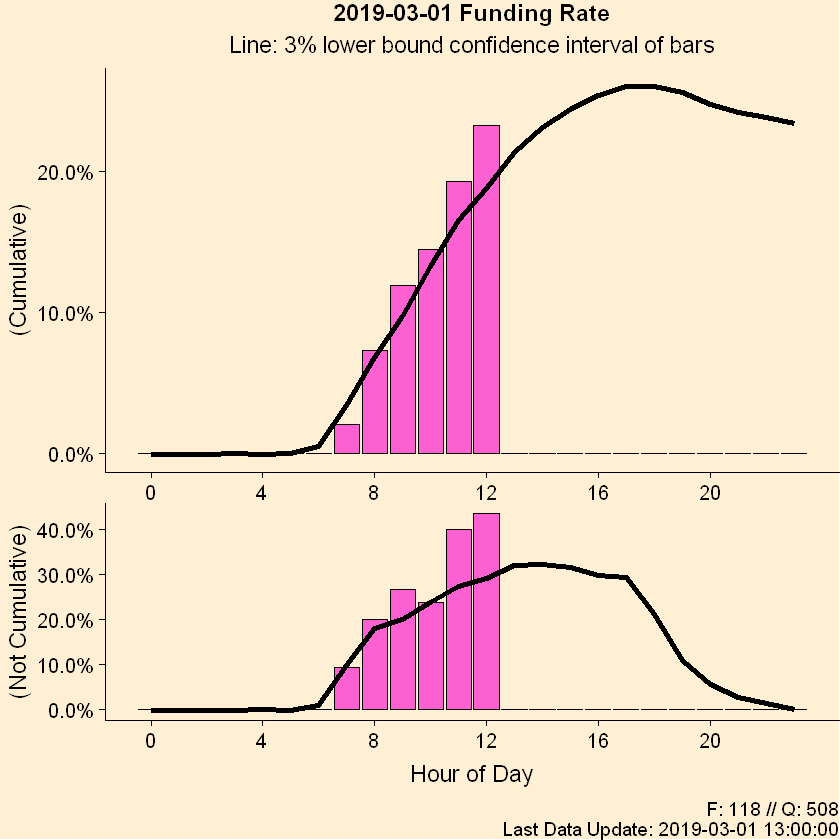

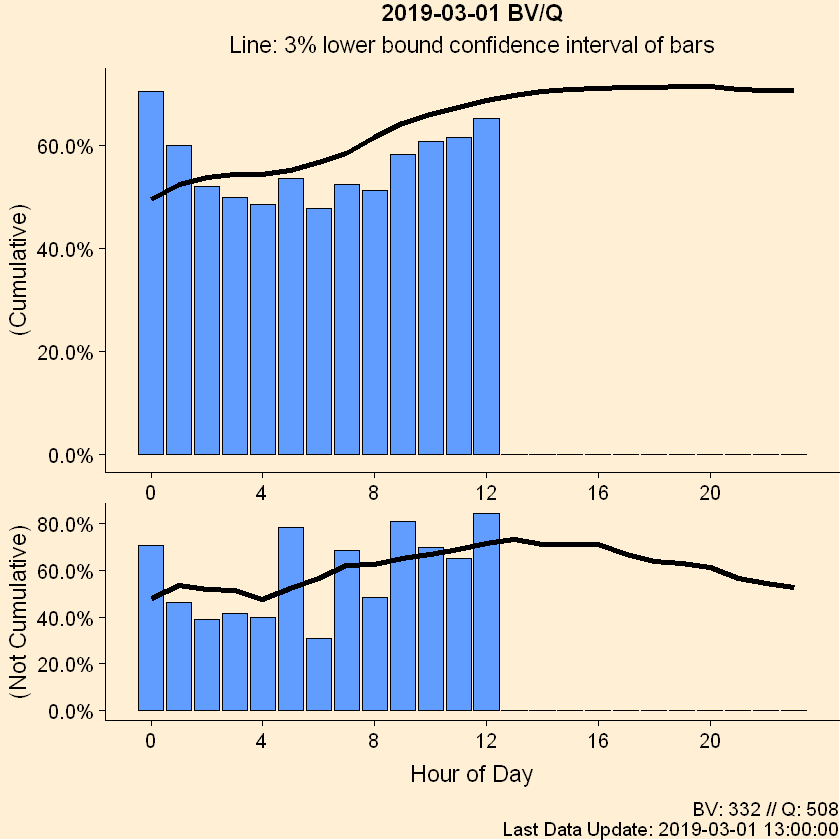

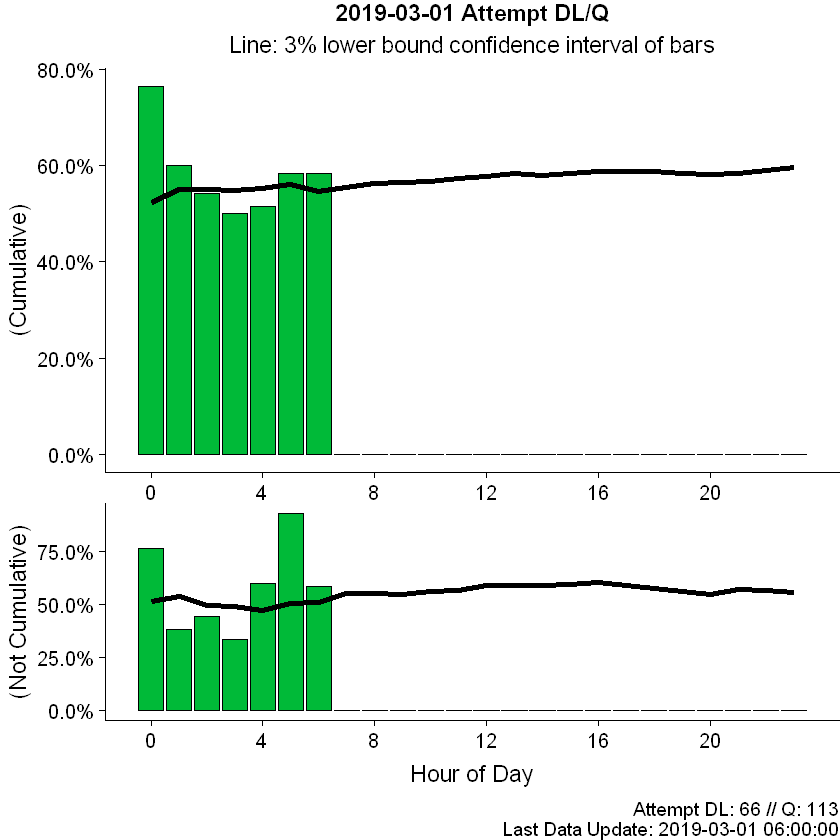

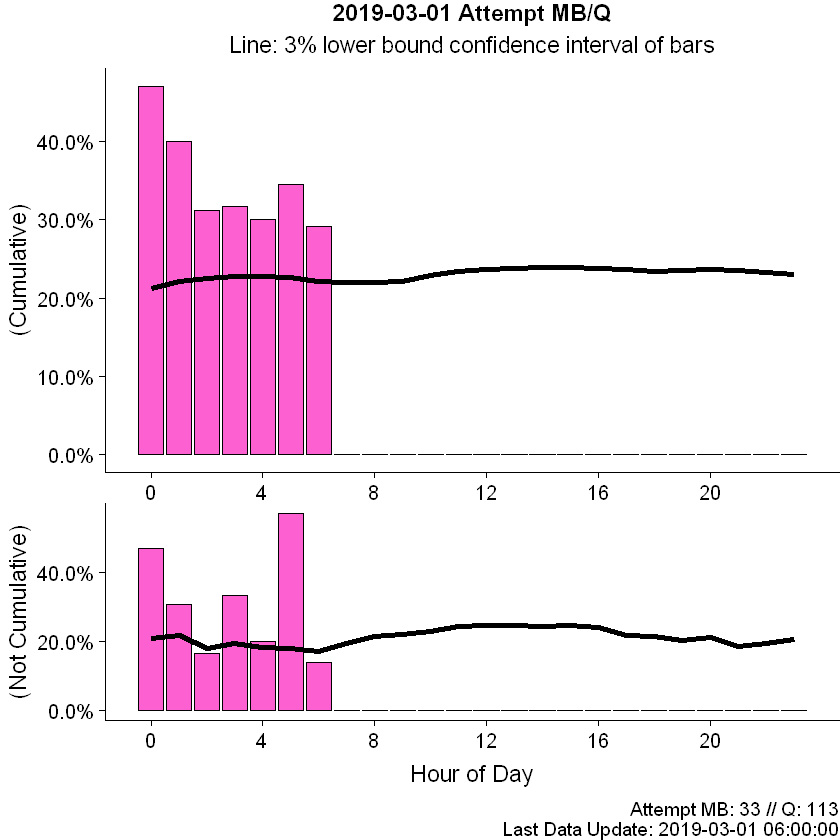

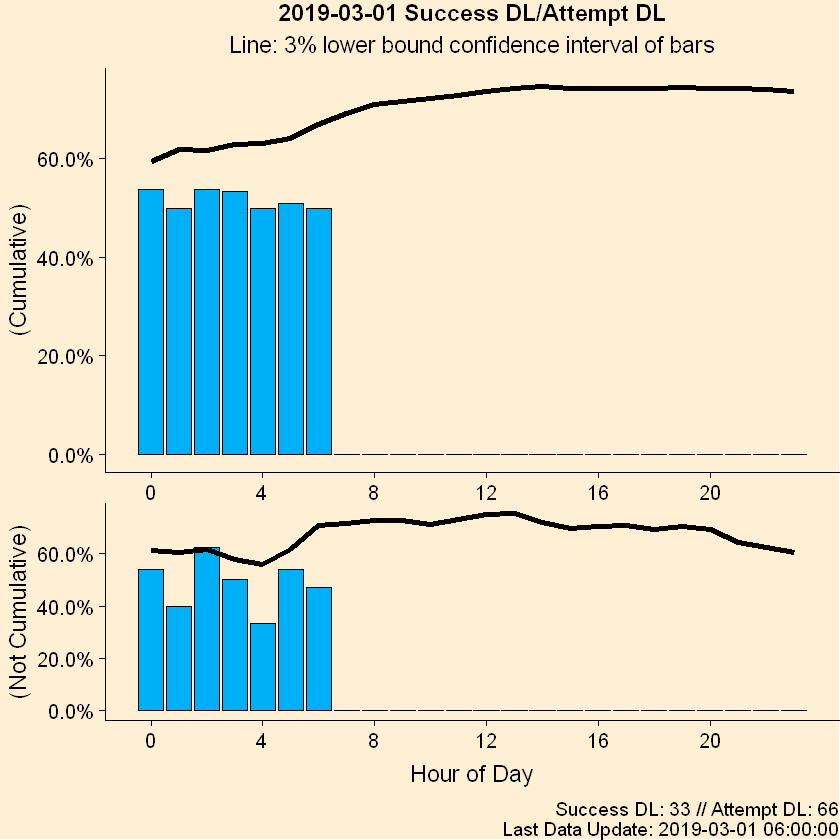

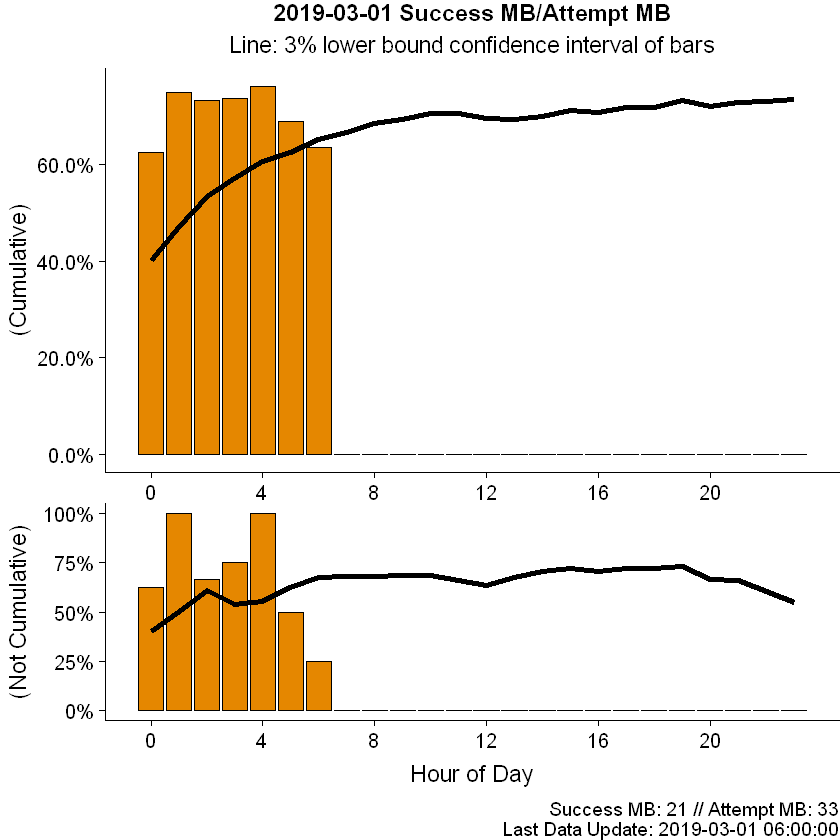

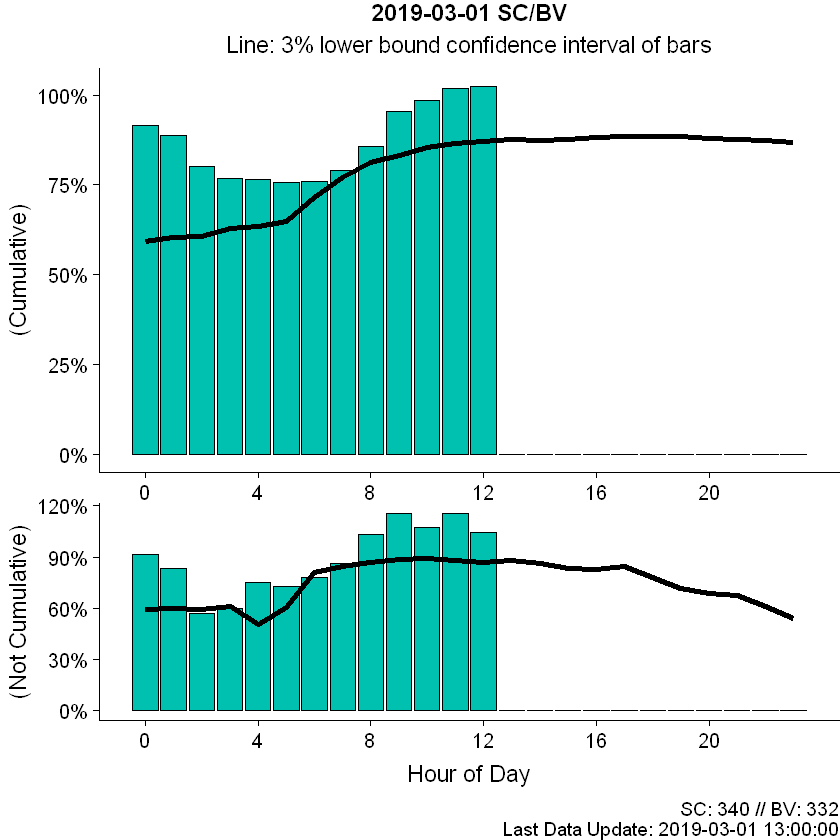

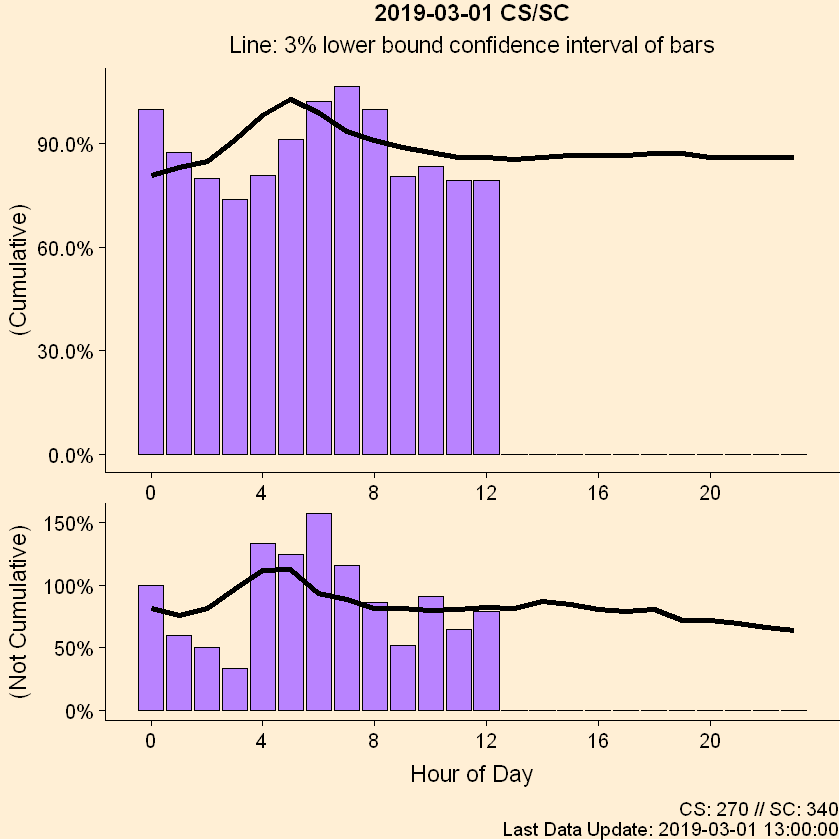

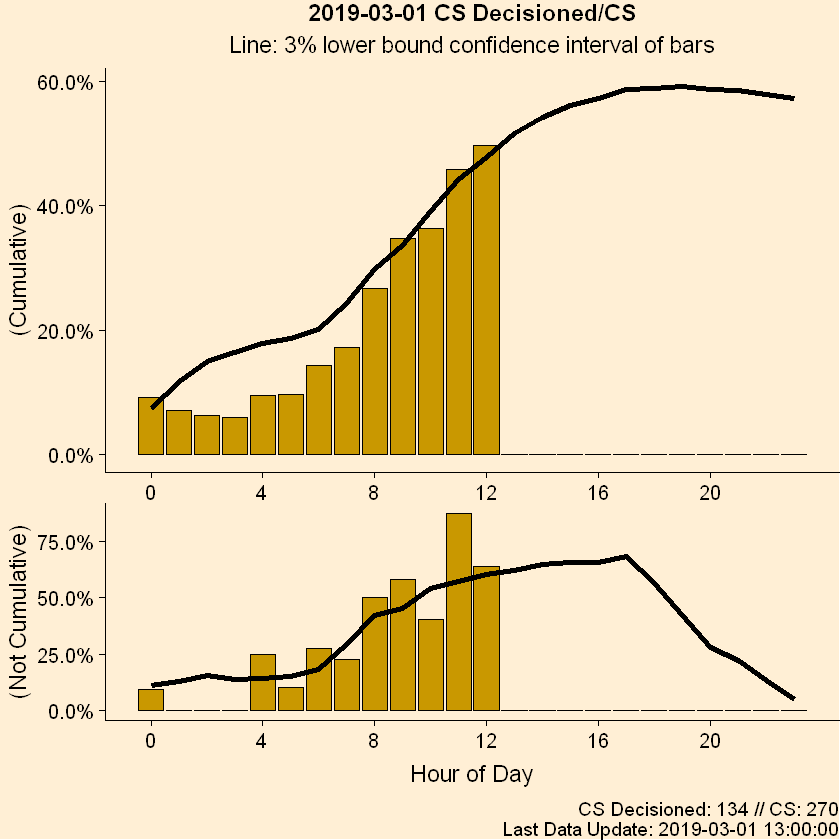

$`1`

$`2`

$`3`

$`4`

$`5`

$`6`

$`7`

$`8`

$`9`

$`10`

$`11`

attr(,"class")
[1] "list"      "ggarrange"

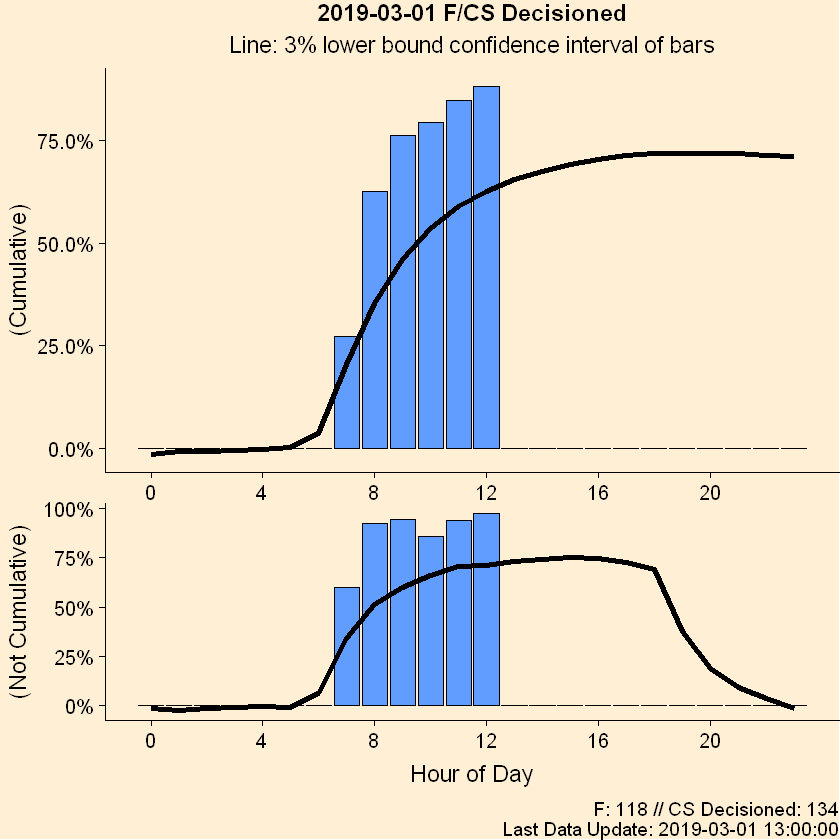

Time difference of 2.346618 mins

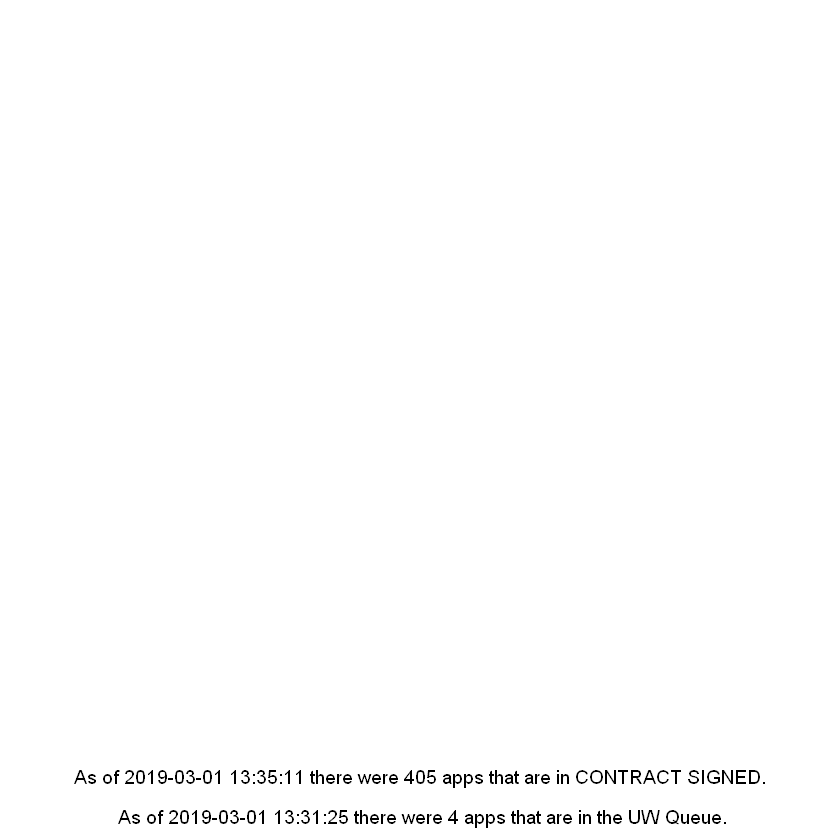

In [45]:
start = Sys.time()
getSalCowplots(data = d, B = 100, alpha = 0.03, smooth.iterations = 1)

Sys.time() - start

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>



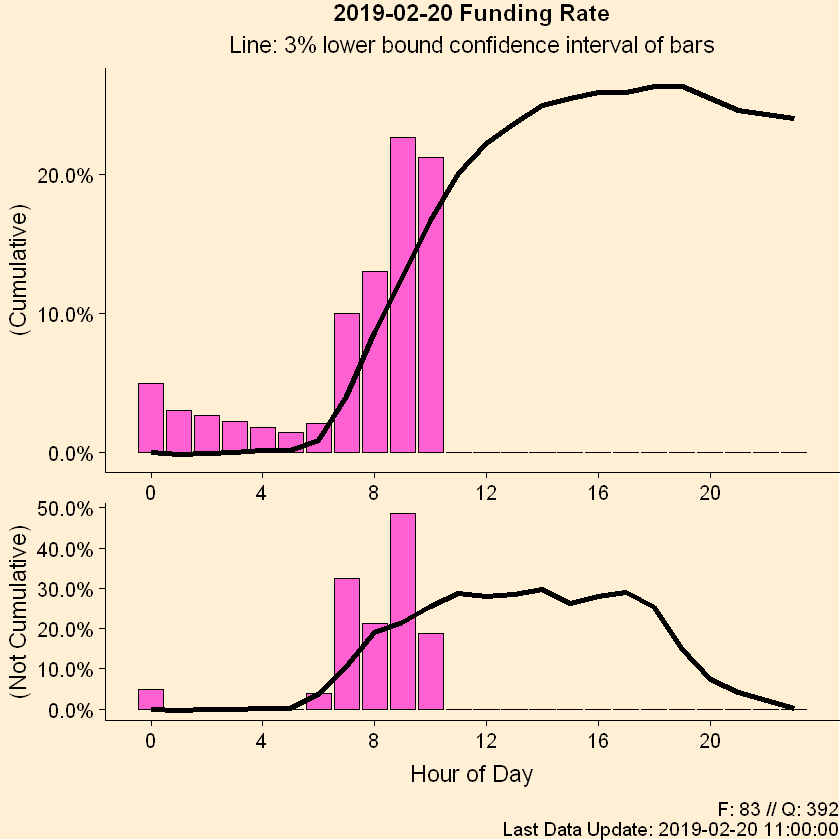

In [46]:
getBootstrapCowplot(
    data.limited = limitDf(
        data = d,
        numerator.string = 'funded',
        denominator.string = 'qualified'
    ),
    numerator.string = 'funded',
    denominator.string = 'qualified',
    B = 100,
    alpha = 0.03,
    smooth.iterations = 1
)

In [ ]:
write.csv(d, file = 'C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/results/2019-02-12-df-export.csv')

In [ ]:
# e = limitDf(
#     data = d,
#     numerator.string = 'bankverified', 
#     denominator.string = 'qualified'
# )

# nrow(e)
# tail(e)

In [ ]:
# start = Sys.time()
# f = getBootstrapInterval(data = e, cumulative = TRUE, B= 100, alpha = 0.03)
# f

# Sys.time() - start

In [ ]:
# B = 100
# alpha = 0.03
# smooth.iterations = 2

In [ ]:
# plot.1 = getFinalPlot(
#     data = e,
#     numerator.string = 'bankverified', 
#     denominator.string = 'qualified',
#     cumulative = TRUE,
#     B = B,
#     alpha = alpha,
#     smooth.iterations = smooth.iterations
# )    
# plot.1

In [ ]:
# plot.2 = getFinalPlot(
#     data = e,
#     numerator.string = 'bankverified', 
#     denominator.string = 'qualified',
#     cumulative = FALSE,
#     B = B,
#     alpha = alpha,
#     smooth.iterations = smooth.iterations
# )    
# plot.2

In [ ]:
# plot.1 = getFinalPlot(
#     data = limitDf(
#         data = d,
#         numerator.string = 'bankverified.dl',
#         denominator.string = 'attempt.dl'
#     ),
#     numerator.string = 'bankverified.dl',
#     denominator.string = 'attempt.dl',
#     cumulative = TRUE,
#     B = B,
#     alpha = alpha,
#     smooth.iterations = smooth.iterations
# )    
# plot.1

In [ ]:
# plot.2 = getFinalPlot(
#     data = limitDf(
#         data = d,
#         numerator.string = 'bankverified.dl',
#         denominator.string = 'attempt.dl'
#     ),
#     numerator.string = 'bankverified.dl',
#     denominator.string = 'attempt.dl',
#     cumulative = FALSE,
#     B = B,
#     alpha = alpha,
#     smooth.iterations = smooth.iterations
# )    
# plot.2

In [ ]:
# plot.3 = getFinalPlot(
#     data = limitDf(
#         data = d,
#         numerator.string = 'bankverified.mb',
#         denominator.string = 'attempt.mb'
#     ),
#     numerator.string = 'bankverified.mb',
#     denominator.string = 'attempt.mb',
#     cumulative = TRUE,
#     B = B,
#     alpha = alpha,
#     smooth.iterations = smooth.iterations
# )    
# plot.3

In [ ]:
# plot.4 = getFinalPlot(
#     data = limitDf(
#         data = d,
#         numerator.string = 'bankverified.mb',
#         denominator.string = 'attempt.mb'
#     ),
#     numerator.string = 'bankverified.mb',
#     denominator.string = 'attempt.mb',
#     cumulative = FALSE,
#     B = B,
#     alpha = alpha,
#     smooth.iterations = smooth.iterations
# )    
# plot.4

In [ ]:
# plot.5 = getFinalPlot(
#     data = limitDf(
#         data = d,
#         numerator.string = 'attempt.ibv',
#         denominator.string = 'qualified'
#     ),
#     numerator.string = 'attempt.ibv',
#     denominator.string = 'qualified',
#     cumulative = TRUE,
#     B = B,
#     alpha = alpha,
#     smooth.iterations = smooth.iterations
# )    
# plot.5

In [ ]:
# plot.6 = getFinalPlot(
#     data = limitDf(
#         data = d,
#         numerator.string = 'attempt.ibv',
#         denominator.string = 'qualified'
#     ),
#     numerator.string = 'attempt.ibv',
#     denominator.string = 'qualified',
#     cumulative = FALSE,
#     B = B,
#     alpha = alpha,
#     smooth.iterations = smooth.iterations
# )    
# plot.6

In [ ]:
# plot.7 = getFinalPlot(
#     data = limitDf(
#         data = d,
#         numerator.string = 'bankverified',
#         denominator.string = 'attempt.ibv'
#     ),
#     numerator.string = 'bankverified',
#     denominator.string = 'attempt.ibv',
#     cumulative = TRUE,
#     B = B,
#     alpha = alpha,
#     smooth.iterations = smooth.iterations
# )    
# plot.7

In [ ]:
# plot.8 = getFinalPlot(
#     data = limitDf(
#         data = d,
#         numerator.string = 'bankverified',
#         denominator.string = 'attempt.ibv'
#     ),
#     numerator.string = 'bankverified',
#     denominator.string = 'attempt.ibv',
#     cumulative = FALSE,
#     B = B,
#     alpha = alpha,
#     smooth.iterations = smooth.iterations
# )    
# plot.8

In [ ]:
# plot.9 = getFinalPlot(
#     data = limitDf(
#         data = d,
#         numerator.string = 'passscorecardratecard',
#         denominator.string = 'bankverified'
#     ),
#     numerator.string = 'passscorecardratecard',
#     denominator.string = 'bankverified',
#     cumulative = TRUE,
#     B = B,
#     alpha = alpha,
#     smooth.iterations = smooth.iterations
# )    
# plot.9

In [ ]:
# plot.10 = getFinalPlot(
#     data = limitDf(
#         data = d,
#         numerator.string = 'passscorecardratecard',
#         denominator.string = 'bankverified'
#     ),
#     numerator.string = 'passscorecardratecard',
#     denominator.string = 'bankverified',
#     cumulative = FALSE,
#     B = B,
#     alpha = alpha,
#     smooth.iterations = smooth.iterations
# )    
# plot.10

In [ ]:
# plot.11 = getFinalPlot(
#     data = limitDf(
#         data = d,
#         numerator.string = 'contractsigned',
#         denominator.string = 'passscorecardratecard'
#     ),
#     numerator.string = 'contractsigned',
#     denominator.string = 'passscorecardratecard',
#     cumulative = TRUE,
#     B = B,
#     alpha = alpha,
#     smooth.iterations = smooth.iterations
# )    
# plot.11

In [ ]:
# plot.12 = getFinalPlot(
#     data = limitDf(
#         data = d,
#         numerator.string = 'contractsigned',
#         denominator.string = 'passscorecardratecard'
#     ),
#     numerator.string = 'contractsigned',
#     denominator.string = 'passscorecardratecard',
#     cumulative = FALSE,
#     B = B,
#     alpha = alpha,
#     smooth.iterations = smooth.iterations
# )    
# plot.12

In [ ]:
# plot.13 = getFinalPlot(
#     data = limitDf(
#         data = d,
#         numerator.string = 'cs_decisioned',
#         denominator.string = 'contractsigned'
#     ),
#     numerator.string = 'cs_decisioned',
#     denominator.string = 'contractsigned',
#     cumulative = TRUE,
#     B = B,
#     alpha = alpha,
#     smooth.iterations = smooth.iterations
# )    
# plot.13

In [ ]:
# plot.14 = getFinalPlot(
#     data = limitDf(
#         data = d,
#         numerator.string = 'cs_decisioned',
#         denominator.string = 'contractsigned'
#     ),
#     numerator.string = 'cs_decisioned',
#     denominator.string = 'contractsigned',
#     cumulative = FALSE,
#     B = B,
#     alpha = alpha,
#     smooth.iterations = smooth.iterations
# )    
# plot.14

In [ ]:
# plot.15 = getFinalPlot(
#     data = limitDf(
#         data = d,
#         numerator.string = 'funded',
#         denominator.string = 'cs_decisioned'
#     ),
#     numerator.string = 'funded',
#     denominator.string = 'cs_decisioned',
#     cumulative = TRUE,
#     B = B,
#     alpha = alpha,
#     smooth.iterations = smooth.iterations
# )    
# plot.15

In [ ]:
# plot.16 = getFinalPlot(
#     data = limitDf(
#         data = d,
#         numerator.string = 'funded',
#         denominator.string = 'cs_decisioned'
#     ),
#     numerator.string = 'funded',
#     denominator.string = 'cs_decisioned',
#     cumulative = FALSE,
#     B = B,
#     alpha = alpha,
#     smooth.iterations = smooth.iterations
# )    
# plot.16

In [ ]:
# start = Sys.time()
# getAllFinalPlots(
#     data = d,
#     B = 100,
#     alpha = 0.03,
#     smooth.iterations = 2    
# )
# Sys.time() - start

In [ ]:
# start = Sys.time()
# x = getSalFinalPlots(
#     data = getDf(
#         reporting.data = getFunnel(date.string = Sys.Date()),
#         dl.data.raw = getAttemptDLRaw(date.string = Sys.Date()),
#         mb.data.raw = getAttemptMBRaw(date.string = Sys.Date())
#     ),
#     B = 100,
#     alpha = 0.03,
#     smooth.iterations = 1    
# )
x
# Sys.time() - start

In [ ]:
# df.bi = getBootstrapInterval(
#     data = df,
#     B = 5000,
#     alpha = 0.03
# )$ci.information

# ggplot() +
# geom_line(
#     data = df.bi,
#     mapping = aes(
#         x = hour.session,
#         y = r.session
#     ),
#     color = 'skyblue',
#     size = 3
# ) +
# geom_line(
#     data = df.bi,
#     mapping = aes(
#         x = hour.session,
#         y = ci.lower
#     ),
#     color = 'red',
#     size = 1,
#     linetype = 6
# ) +
# geom_point(
#     data = makeCumulative(data = df),
#     mapping = aes(
#         x = hourofday,
#         y = dl.hist.cum/q.hist.cum
#     ),
#     color = 'black',
#     size = 0.8,
#     alpha = 0.1
# ) +
# # geom_ribbon(
# #     data = makeCumulative(data = df) %>%
# #         group_by(
# #             hourofday
# #         ) %>%
# #         summarize(
# #             ribbon.lower = min(dl.hist.cum/q.hist.cum),
# #             ribbon.upper = max(dl.hist.cum/q.hist.cum)
# #         ), 
# #     mapping = aes(
# #         x = hourofday,
# #         ymin = ribbon.lower,
# #         ymax = ribbon.upper
# #     ),
# #     color = 'black',
# #     size = 0.8,
# #     alpha = 0.1
# # ) +
# scale_y_continuous(
#     labels = scales::percent,
# #     limits = c(
# #         min(dl.hist.cum/q.hist.cum),
# #         max(dl.hist.cum/q.hist.cum),
# #     ) 
#     limits = c(0.20,0.70)
# ) 


# # + 
# # labs(
# #     x ="Time of Day", 
# #     y = "Success/Q", 
# #     title = paste(
# #         "DL ", getSessionInfo(data = df)$date,
# #         "\n", "Bars: Non-Cohorted DL Success/Q (Cumulative)", 
# #         "\n", "Line: 5% lower bound confidence interval of bars")
# # ) + 
# # geom_line(
# #     aes(
# #         x = hour.session, 
# #         y = ci.lower
# #     ), 
# #     color = 'red', 
# #     size=1
# # ) + 
# # # geom_line(
# # #     aes(
# # #         x = hour.session, 
# # #         y = ci.upper
# # #     ), 
# # #     color = 'blue', 
# # #     size=1
# # # ) + 
# # scale_x_continuous(
# #     breaks = seq(0,23,4)
# # )# + geom_line(aes(x=hourofday, y=upper), color='springgreen4', size=1) + scale_y_continuous(labels=scales::percent) + scale_x_continuous(breaks=seq(0,23,4))
